## IBM Quantum Challenge Fall 2021

# Challenge 3: 量子機械学習による画像分類

<div id='problem'></div>
<div class="alert alert-block alert-info">
    
Quantum Challengeに最適な環境で取り組んでいただくために、右上のアカウントメニューより **light** モードを選択されることをお勧めします。

## はじめに

機械学習技術は，近年その高い性能と汎用性の高さから非常に注目を集めています。実際，アルゴリズムの発展や計算資源の増大に伴って，様々な産業において実用化が進められています。その代表例の一つは画像認識です。機械学習によって人間と同等以上の精度で画像を分類できるようになっています。これにより，例えば衣料画像の自動分類が可能となり，アパレル分野におけるネットショッピングがより便利になりました。

量子計算を機械学習に応用することによって，その性能を更に向上することができる可能性が近年示されています。このような枠組みを量子機械学習と呼び，量子サポートベクターマシン (QSVM) や量子敵対的生成ネットワーク (QGAN) など，様々なアルゴリズムが提案されています。このチャレンジでは， QSVMを用いて衣料画像の画像分類に取り組みます。

QSVMは，代表的な古典機械学習アルゴリズムの一つであるサポートベクターマシン (SVM) に量子計算を適用したもので押す。一口にQSVMといっても様々なアプローチが存在し，誤り耐性量子計算を前提として計算の高速化を目指すものや，現在のノイズありデバイスを想定して表現力の向上を目指すものなどがあります。今回のチャレンジは後者に注目したものとなっています。

今回扱うQSVMの実装では，量子部分をどのように構成するか，具体的には特徴マップの構成について工夫することが可能です。これは，複雑な特徴マップはより大きな表現力が期待される一方で，ノイズの影響をより受けやすくなるというトレードオフが存在するためで，そのバランスを考慮して構成を考える必要があります。特にノイズを多く含むデバイスを利用する場合に，この点は非常に重要となってきます。

このチャレンジで登場する概念の多くは，2021 Qiskit Global Summer School (QGSS) で解説されています。教材や講義動画は公開されているので，それらも合わせて学習することが推奨されます。各パートで対応する講義動画のリンクを付記してあるので，参考にしてください。

<center><div><img src="./resources/ecommerce.jpg" width="640" /></div></center>

## Challenge
<div class="alert alert-block alert-success">

**目標**

多クラス分類タスクに対してQSVMを実装し，正確に画像を分類してください.
    
**構成**

初めに，単純なデータセットの二値分類を題材として，QSVMをどのように構成するか学びます。次に，それを別のデータセットの3クラス分類というより複雑な問題設定に適用します。

**1. チュートリアル - QSVMによるMNIST二値分類:** QSVMの典型的なワークフローを学びましょう。

**2. チャレンジ - QSVMによるFashion-MNIST多値分類:** QSVMの２クラス分類器を用いて，3クラス分類器を実装しましょう。次元と特徴マップを調整することによって，より小さい特徴マップ回路によって高い正解率を達成しましょう。

</div>

<div class="alert alert-block alert-info">

このChallengeを始める前に、QSVMをつかった分類について学ぶために [**Qiskit Machine Learning Demo Session with Anton Dekusar**](https://youtu.be/claoY57eVIc?t=1814) と [**demo notebook**](https://github.com/qiskit-community/qiskit-application-modules-demo-sessions/tree/main/qiskit-machine-learning) をご覧になることをお勧めします。
</div>

In [8]:
# General imports
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
from pylab import cm
import warnings

warnings.filterwarnings("ignore")

# scikit-learn imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Qiskit imports
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel

## Part 1: チュートリアル - QSVMによるMNIST二値分類

このパートでは，QSVMによって手書き数字の4と9を分類します。このチュートリアルを通して，QSVMを二値分類に適用するワークフローについて学びましょう。

QGSS教材:
- Lab 3: https://www.youtube.com/watch?v=GVhCOTzAkCM&list=PLOFEBzvs-VvqJwybFxkTiDzhf5E11p8BI&index=17

### 1. データの準備

ここで扱うデータは，MNISTという有名な手書き数字画像データセットの一部です。このサブセットは手書き数字の"4"と"9"からなっており，ここではそれらの分類に取り組みます。

このデータセットは，80個のラベル付き訓練データと20個のラベル無しテストデータの，計100データからなります。各データは，28×28の手書き数字データ画像を配列にしたもので，それぞれの値は0 (白) から255 (黒) までの整数となっています。このようなデータセットをQSVMによって分類するためには，まず値を-1から1の間にスケーリングし，その次元を量子ビットの数まで圧縮する必要があります。(ここでは5次元としています)



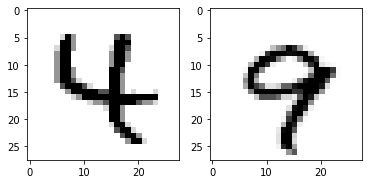

In [3]:
# Load MNIST dataset
DATA_PATH = './resources/ch3_part1.npz'
data = np.load(DATA_PATH)

sample_train = data['sample_train']
labels_train = data['labels_train']
sample_test = data['sample_test']

# Split train data
sample_train, sample_val, labels_train, labels_val = train_test_split(
    sample_train, labels_train, test_size=0.2, random_state=42)

# Visualize samples
fig = plt.figure()

LABELS = [4, 9]
num_labels = len(LABELS)
for i in range(num_labels):
    ax = fig.add_subplot(1, num_labels, i+1)
    img = sample_train[labels_train==LABELS[i]][0].reshape((28, 28))
    ax.imshow(img, cmap="Greys")

In [4]:
# Standardize
ss = StandardScaler()
sample_train = ss.fit_transform(sample_train)
sample_val = ss.transform(sample_val)
sample_test = ss.transform(sample_test)

# Reduce dimensions
N_DIM = 5
pca = PCA(n_components=N_DIM)
sample_train = pca.fit_transform(sample_train)
sample_val = pca.transform(sample_val)
sample_test = pca.transform(sample_test)

# Normalize
mms = MinMaxScaler((-1, 1))
sample_train = mms.fit_transform(sample_train)
sample_val = mms.transform(sample_val)
sample_test = mms.transform(sample_test)

### 2. データのエンコーディング

次に，古典的なデータを量子特徴マップによって状態空間にエンコードしていきます。どの特徴マップを使用するの選択は重要であり，扱うデータセットに依存します。ここでは，Qiskitに用意されている特徴マップを確認し，選択・調整できるようになることを目指します。

### 2.1 量子特徴マップ

量子特徴マップ $\phi(\mathbf{x})$ とはその名の通り，古典的な特徴ベクトル $\mathbf{x}$ から量子状態 $|\Phi(\mathbf{x})\rangle\langle\Phi(\mathbf{x})|$ への写像です。これは，初期状態 $|0\rangle^{n}$ (_n_ はエンコーディングに使われる量子ビット数) にユニタリー演算 $|0\rangle^{n}$ を適用することによって実現します。

現在Qiskitで利用可能な以下の特徴マップは，[**_Havlicek et al_.  Nature **567**, 209-212 (2019)**](https://www.nature.com/articles/s41586-019-0980-2) で紹介されているものです。特に `ZZFeatureMap` は古典的にシミュレートすることが難しく，小中規模な量子デバイス上でも実装できると見込まれています。

- [**`PauliFeatureMap`**](https://qiskit.org/documentation/stubs/qiskit.circuit.library.PauliFeatureMap.html)
- [**`ZZFeatureMap`**](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZFeatureMap.html)
- [**`ZFeatureMap`**](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html)

`PauliFeatureMap`は以下のように使用できます。

```python
PauliFeatureMap(feature_dimension=None, reps=2, 
                entanglement='full', paulis=None, 
                data_map_func=None, parameter_prefix='x',
                insert_barriers=False)
```

ユニタリ演算子は以下のように記述されます。

$$ \mathcal{U}_{\Phi(\mathbf{x})}=\prod_d U_{\Phi(\mathbf{x})}H^{\otimes n},\ U_{\Phi(\mathbf{x})}=\exp\left(i\sum_{S\subseteq[n]}\phi_S(\mathbf{x})\prod_{k\in S} P_i\right), $$

これは以下の回路図に示すように，エンタングルメントを生成するブロック $U_{\Phi(\mathbf{x})}$ とアダマールゲートの層が交互に連なった形をしています。

<div><img src="./resources/featuremap.png" width="1000" /></div>

各エンタングルメント生成ブロック $U_{\Phi(\mathbf{x})}$ の中で， $P_i \in \{ I, X, Y, Z \}$はパウリ行列を表し，添字 $S$ は量子ビット間の接続に対応しています。 ($S \in \{\binom{n}{k}\,\ k = 1,... n \}$) デフォルトでデータのマッピング関数 $\phi_S(\mathbf{x})$ は以下のようになっています。

$$\phi_S:\mathbf{x}\mapsto \Bigg\{\begin{array}{ll}
    x_i & \mbox{if}\ S=\{i\} \\
        (\pi-x_i)(\pi-x_j) & \mbox{if}\ S=\{i,j\}
    \end{array}$$

$k = 1, P_0 = Z$のときに，これは`ZFeatureMap`となります。

$$\mathcal{U}_{\Phi(\mathbf{x})} = \left( \exp\left(i\sum_j \phi_{\{j\}}(\mathbf{x}) \, Z_j\right) \, H^{\otimes n} \right)^d.$$

これは以下のように使用できます。
```python
ZFeatureMap(feature_dimension, reps=2, 
            data_map_func=None, insert_barriers=False)
```

/opt/conda/lib/python3.8/site-packages/sympy/core/expr.py:2451: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


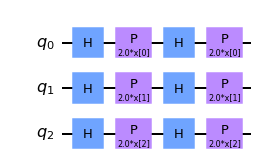

In [5]:
# 3 features, depth 2
map_z = ZFeatureMap(feature_dimension=3, reps=2)
map_z.decompose().draw('mpl')

この特徴マップはエンタングルメントを伴わないことから，古典的なシミュレーションが容易であり，量子的な優位性が得られないことに注意してください。

$k = 2, P_0 = Z, P_1 = ZZ$のとき，`ZZFeatureMap`となります。
$$\mathcal{U}_{\Phi(\mathbf{x})} = \left( \exp\left(i\sum_{jk} \phi_{\{j,k\}}(\mathbf{x}) \, Z_j \otimes Z_k\right) \, \exp\left(i\sum_j \phi_{\{j\}}(\mathbf{x}) \, Z_j\right) \, H^{\otimes n} \right)^d.$$ 

これは以下のように使用できます。
```python
ZZFeatureMap(feature_dimension, reps=2, 
             entanglement='full', data_map_func=None, 
             insert_barriers=False)
```

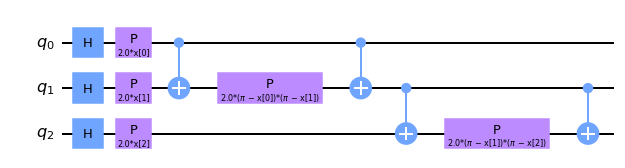

In [6]:
# 3 features, depth 1, linear entanglement
map_zz = ZZFeatureMap(feature_dimension=3, reps=1, entanglement='linear')
map_zz.decompose().draw('mpl')

この特徴マップにはエンタングルメントが含まれており，その形を以下のように変更することができます。

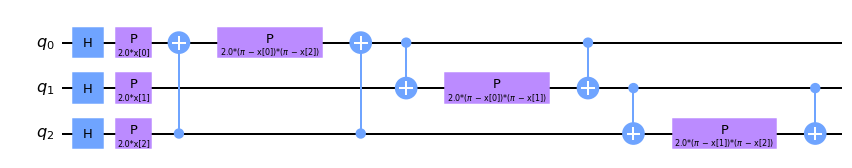

In [7]:
# 3 features, depth 1, circular entanglement
map_zz = ZZFeatureMap(feature_dimension=3, reps=1, entanglement='circular')
map_zz.decompose().draw('mpl')

特徴マップ中のパウリゲートをカスタマイズすることも可能です。例えば $P_0 = X, P_1 = Y, P_2 = ZZ$ とする場合は以下のようになります。

$$\mathcal{U}_{\Phi(\mathbf{x})} = \left( \exp\left(i\sum_{jk} \phi_{\{j,k\}}(\mathbf{x}) \, Z_j \otimes Z_k\right) \, \exp\left(i\sum_{j} \phi_{\{j\}}(\mathbf{x}) \, Y_j\right) \, \exp\left(i\sum_j \phi_{\{j\}}(\mathbf{x}) \, X_j\right) \, H^{\otimes n} \right)^d.$$ 

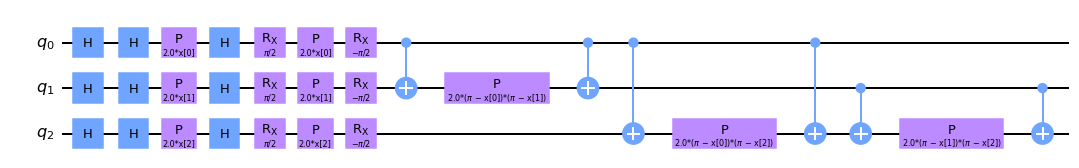

In [8]:
# 3 features, depth 1
map_pauli = PauliFeatureMap(feature_dimension=3, reps=1, paulis = ['X', 'Y', 'ZZ'])
map_pauli.decompose().draw('mpl')

パラメータ付き回路を特徴マップとして用いるためには，[`NLocal`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.NLocal.html) と [`TwoLocal`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html) を利用することができます。

```python
TwoLocal(num_qubits=None, reps=3, rotation_blocks=None, 
         entanglement_blocks=None, entanglement='full',  
         skip_unentangled_qubits=False, 
         skip_final_rotation_layer=False, 
         parameter_prefix='θ', insert_barriers=False, 
         initial_state=None)
```

```python
NLocal(num_qubits=None, reps=1, rotation_blocks=None, 
       entanglement_blocks=None, entanglement=None,   
       skip_unentangled_qubits=False, 
       skip_final_rotation_layer=False, 
       overwrite_block_parameters=True, 
       parameter_prefix='θ', insert_barriers=False, 
       initial_state=None, name='nlocal')
```

どちらも，ローテーション層とエンタングルメント層を交互に繰り返すパラメータ付き回路を作成します。`NLocal` では各ブロックが任意のサイズとできる一方で，`TwoLocal`ではローテーション層は一量子ビットゲート，エンタングルメント層は2量子ビットゲートに限定されます。

例えば以下は `TwoLocal` の回路で，回転層に$R_y$と$R_Z$ゲート，エンタングルメント層に $CX$ゲートを用いて，循環的なエンタングルメントを実現しています。

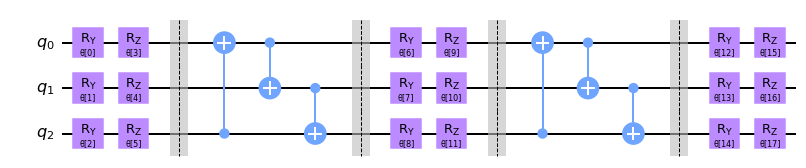

In [9]:
twolocal = TwoLocal(num_qubits=3, reps=2, rotation_blocks=['ry','rz'], 
               entanglement_blocks='cx', entanglement='circular', insert_barriers=True)
twolocal.decompose().draw('mpl')

同じものは，`NLocal`で以下のように実現できます。

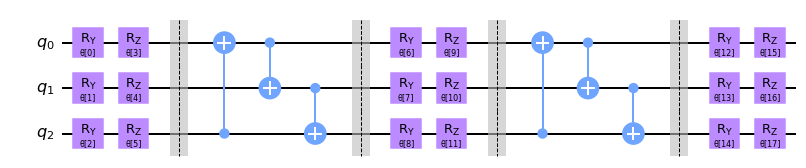

In [10]:
twolocaln = NLocal(num_qubits=3, reps=2,
               rotation_blocks=[RYGate(Parameter('a')), RZGate(Parameter('a'))], 
               entanglement_blocks=CXGate(), 
               entanglement='circular', insert_barriers=True)
twolocaln.decompose().draw('mpl')

それでは，1個目の訓練データを `PauliFeatureMap`によってエンコードしてみましょう。

In [11]:
print(f'First training data: {sample_train[0]}')

First training data: [-0.47556168 -0.42256422  0.30055054  0.00500803 -0.89445195]


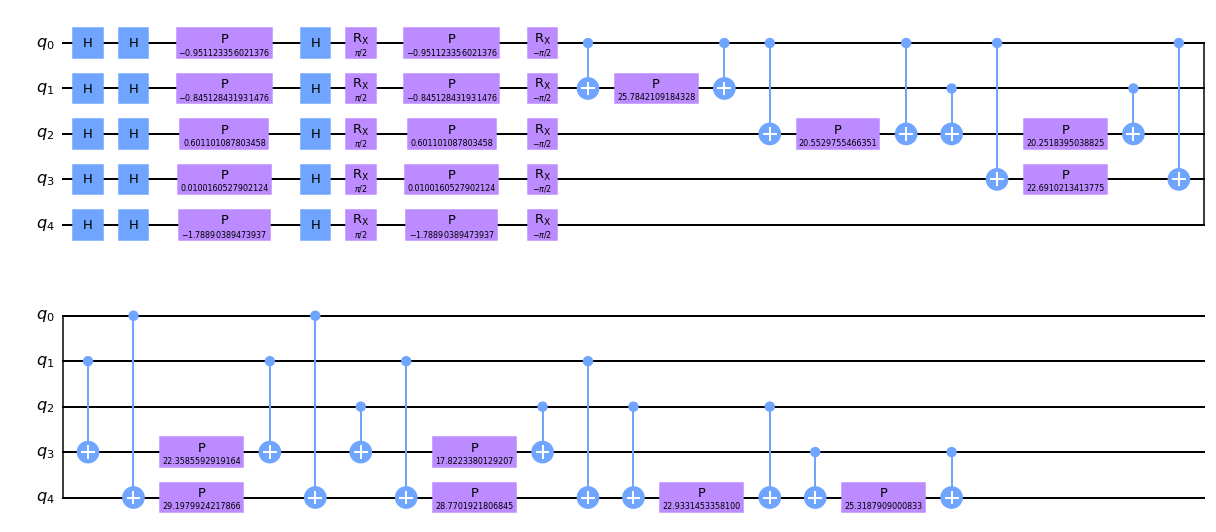

In [12]:
encode_map = PauliFeatureMap(feature_dimension=N_DIM, reps=1, paulis = ['X', 'Y', 'ZZ'])
encode_circuit = encode_map.bind_parameters(sample_train[0])
encode_circuit.decompose().draw(output='mpl')

</div>
    
<div class="alert alert-block alert-success">

<b>Challenge 3a</b> 

5次元データをエンコードする特徴マップを，3回の繰り返しと'circular'型のエンタングルメントを伴う`ZZFeatureMap`によって構成してください。(ただし繰り返し数とエンタングルメントの種類の他は，デフォルト設定のままとしてください)
    
</div>

提出フォーマット:
```python
ex3a_fmap = ZZFeatureMap(...)
```

In [13]:
##############################
# Provide your code here
from qiskit.circuit.library import ZZFeatureMap

ex3a_fmap = ZZFeatureMap(feature_dimension=5, reps=3, entanglement='circular')



##############################

In [14]:
# 答えを確認して以下のコードで提出します
from qc_grader import grade_ex3a
grade_ex3a(ex3a_fmap)

Submitting your answer for 3a. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


### 2.2 量子カーネル推定

量子特徴マップ $\phi(\mathbf{x})$ から量子カーネル $k(\mathbf{x}_i,\mathbf{x}_j)= \phi(\mathbf{x}_j)^\dagger\phi(\mathbf{x}_i)$ を考えることができます。これは $\mathbf{x}_i$ と $\mathbf{x}_j$ が近いときにより大きな値となることから，類似性の尺度として見ることができます。

有限次元のデータを考える際には，この量子カーネルを行列 $K_{ij} = \left| \langle \phi^\dagger(\mathbf{x}_j)| \phi(\mathbf{x}_i) \rangle \right|^{2}$ として表すことができます。このカーネル行列の各要素は，量子コンピュータ上で遷移確率を測定することにより，計算することが可能です。

$$
\left| \langle \phi^\dagger(\mathbf{x}_j)| \phi(\mathbf{x}_i) \rangle \right|^{2} = 
\left| \langle 0^{\otimes n} | \mathbf{U_\phi^\dagger}(\mathbf{x}_j) \mathbf{U_\phi}(\mathbf{x_i}) | 0^{\otimes n} \rangle \right|^{2}
$$

ここで特徴マップとしては，$n$量子ビットに対するユニタリー変換 $\mathbf{U_\phi}(\mathbf{x})$ として記述されるパラメータ付き回路を仮定しています。

これにより，量子カーネル行列の推定値を得ることができ，サポートベクターマシンなどのカーネル機械学習アルゴリズムに利用することができます。

[***Havlicek et al*.  Nature 567, 209-212 (2019)**](https://www.nature.com/articles/s41586-019-0980-2)で議論されているように，量子カーネルに基づくアルゴリズムは，その量子カーネルを古典的に推定するのが難しい場合にのみ，古典的な手法に対して優位性をもつ可能性があります。また古典的に量子カーネルを推定することの難しさは，量子優位性を得るための必要条件に過ぎず，十分条件ではありません。

しかし，[***Liu et al.* arXiv:2010.02174 (2020)**](https://arxiv.org/abs/2010.02174)では，全ての古典的な学習器に対して量子優位性をもつような問題の存在が示されました。

データの前準備ができたら，PauliFeatureMapを使って`QuantumKernel`クラスを設定し，`BasicAer``statevector_simulator`を用いてカーネル行列を推定します。

In [15]:
pauli_map = PauliFeatureMap(feature_dimension=N_DIM, reps=1, paulis = ['X', 'Y', 'ZZ'])
pauli_kernel = QuantumKernel(feature_map=pauli_map, quantum_instance=Aer.get_backend('statevector_simulator'))

カーネル行列の成分の一つである，1個目と2個目の訓練データ間の遷移確率を算出してみましょう。

In [16]:
print(f'First training data : {sample_train[0]}')
print(f'Second training data: {sample_train[1]}')

First training data : [-0.47556168 -0.42256422  0.30055054  0.00500803 -0.89445195]
Second training data: [ 0.05258891 -0.67206403 -0.2815717   0.02243049 -0.38656684]


まず回路を作成して，描画してみます。

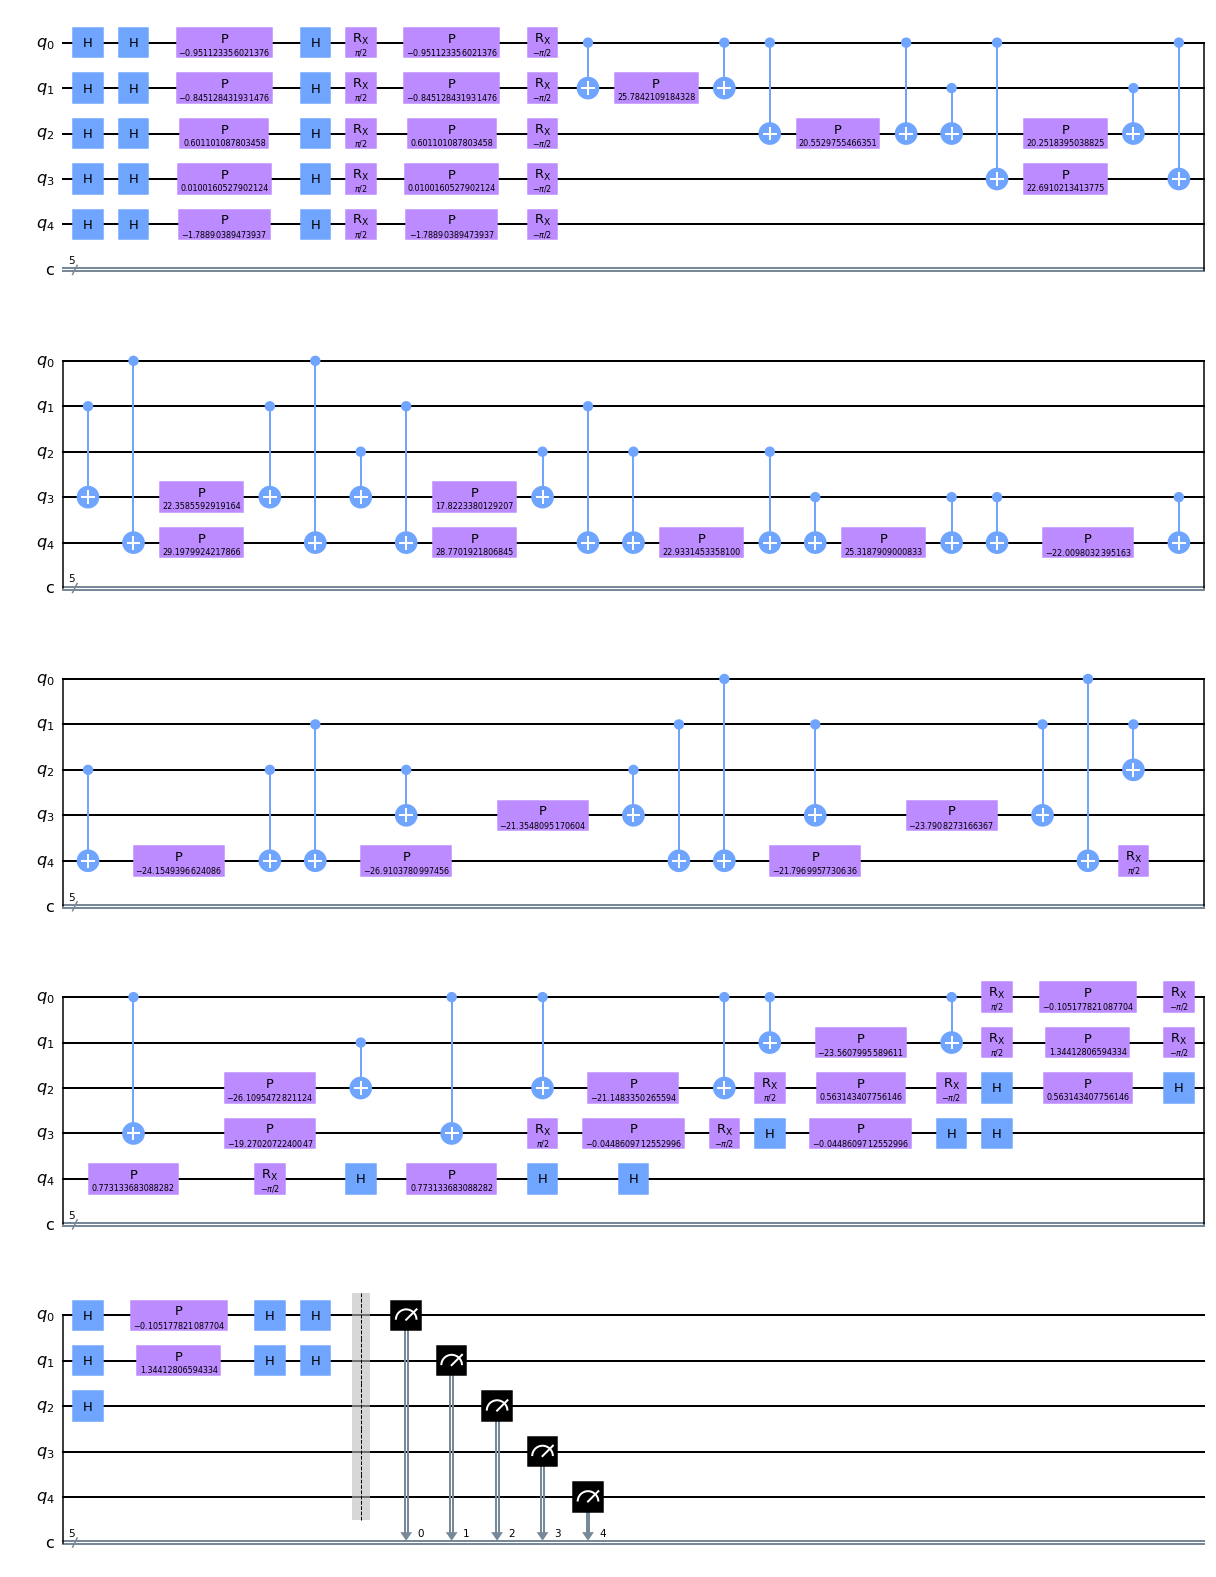

In [17]:
pauli_circuit = pauli_kernel.construct_circuit(sample_train[0], sample_train[1])
pauli_circuit.decompose().decompose().draw(output='mpl')

回路が左右対称になっていて，一方がデータの片方を，もう一方がデータのもう片方をエンコードしていることに注目してください。

次に，この回路のシミュレーションを行います。

In [18]:
backend = Aer.get_backend('qasm_simulator')
job = execute(pauli_circuit, backend, shots=8192, 
              seed_simulator=1024, seed_transpiler=1024)
counts = job.result().get_counts(pauli_circuit)

遷移確率は，ゼロ状態のカウント数の割合として得られます。

In [19]:
print(f"Transition amplitude: {counts['0'*N_DIM]/sum(counts.values())}")

Transition amplitude: 0.0284423828125


このプロセスを，訓練データの組ごとに繰り返して訓練カーネル行列を埋め，訓練データとテストデータの組ごとに繰り返してテストカーネル行列を埋めます。なお各行列は対称行列になるので，計算時間を短縮するために要素の半分だけを計算します。

ここでは，訓練カーネル行列とテストカーネル行列を計算し，プロットしています。

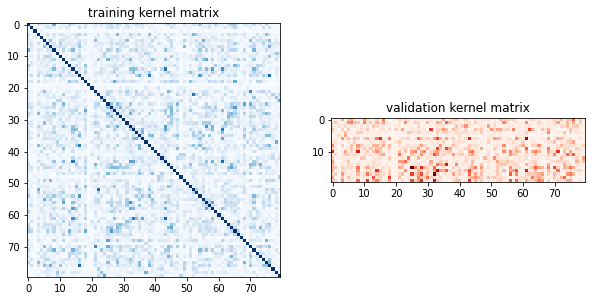

In [20]:
matrix_train = pauli_kernel.evaluate(x_vec=sample_train)
matrix_val = pauli_kernel.evaluate(x_vec=sample_val, y_vec=sample_train)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_val),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("validation kernel matrix")
plt.show()

</div>
    
<div class="alert alert-block alert-success">

<b>Challenge 3b</b> 

$x = (-0.5, -0.4, 0.3, 0, -0.9)$ と $y = (0, -0.7, -0.3, 0, -0.4)$ の間の遷移確率を，繰り返し3回・エンタングルメント'circular'の'ZZFeatureMap'を用いて計算してください。(ただし繰り返し数とエンタングルメントの種類の他は，デフォルト設定のままとしてください) また `shots=8192`, `seed_simulator=1024` と `seed_transpiler=1024`　の `qasm_simulator` でシミュレートしてください。
    
</div>

In [21]:
x = [-0.5, -0.4, 0.3, 0, -0.9]
y = [0, -0.7, -0.3, 0, -0.4]

##############################
# Provide your code here

# ZZFeatureMapとカーネルの作成
N_DIM = 5
zzfmap = ZZFeatureMap(feature_dimension=N_DIM, reps=3, entanglement='circular')
zzfkernel = QuantumKernel(feature_map=zzfmap, quantum_instance=Aer.get_backend('statevector_simulator'))

# circuit作成
circuit = zzfkernel.construct_circuit(x, y)
# circuit.decompose().decompose().draw(output='mpl')

# job実行
shots = 8192
seed_simulator = 1024
seed_transpiler = 1024
backend = Aer.get_backend('qasm_simulator')
job = execute(circuit, backend, shots=shots, 
              seed_simulator=seed_simulator, seed_transpiler=seed_transpiler)
counts = job.result().get_counts(circuit)

ex3b_amp = counts['0'*N_DIM]/sum(counts.values())


##############################

In [22]:
# 答えを確認して以下のコードで提出します
from qc_grader import grade_ex3b
grade_ex3b(ex3b_amp)

Submitting your answer for 3b. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


QGSS教材:
- [**Kernel Trick (Lecture 6.1)**](https://www.youtube.com/watch?v=m6EzmYsEOiI&list=PLOFEBzvs-VvqJwybFxkTiDzhf5E11p8BI&index=14)
- [**Kernel Trick (Lecture 6.2)**](https://www.youtube.com/watch?v=zw3JYUrS-v8&list=PLOFEBzvs-VvqJwybFxkTiDzhf5E11p8BI&index=15)

### 2.3 量子サポートベクターマシン (QSVM)

[***Havlicek et al*.  Nature 567, 209-212 (2019)**](https://www.nature.com/articles/s41586-019-0980-2)で提案された，量子カーネルサポートベクター分類アルゴリズムは，以下のステップから構成されています。

<div><img src="./resources/qsvc.png" width="1000"></div> 

1. 量子カーネル行列を訓練用とテスト用それぞれで構築する。
    1. 訓練データの各ペア　$\mathbf{x}_{i},\mathbf{x}_j$ で，特徴マップを適用し，遷移確率を測定する。 $ K_{ij} = \left| \langle 0 | \mathbf{U}^\dagger_{\Phi(\mathbf{x_j})} \mathbf{U}_{\Phi(\mathbf{x_i})} | 0 \rangle \right|^2 $
    2. 訓練データ $\mathbf{x_i} $とテストデータ $\mathbf{y_j}$ の各ペアで，特徴マップを適用し，遷移確率を測定する。$ K_{ij} = \left| \langle 0 | \mathbf{U}^\dagger_{\Phi(\mathbf{y_j})} \mathbf{U}_{\Phi(\mathbf{x_i})} | 0 \rangle \right|^2 $
2. 量子カーネル行列を古典的なサポートベクターマシン分類アルゴリズムで使用する。

`scikit-learn`の`svc`アルゴリズムでは，二つの方法でカーネルを定義することができます。 [**define a custom kernel**](https://scikit-learn.org/stable/modules/svm.html#custom-kernels) 一つはカーネルを呼び出し可能な関数として提供する方法で，もう一つはカーネル行列を事前に計算しておく方法です。どちらもQiskitの`QuantumKernel`クラスを適用することができます。

以下のコードは，先に計算した訓練用とテスト用のカーネル行列を受け取り，`scikit-learn`の`svc`アルゴリズムに提供しています：

In [23]:
pauli_svc = SVC(kernel='precomputed')
pauli_svc.fit(matrix_train, labels_train)
pauli_score = pauli_svc.score(matrix_val, labels_val)

print(f'Precomputed kernel classification test score: {pauli_score*100}%')

Precomputed kernel classification test score: 70.0%


QGSS教材:
- [**Classical SVM (Lecture 4.2)**](https://www.youtube.com/watch?v=lpPij21jnZ4&list=PLOFEBzvs-VvqJwybFxkTiDzhf5E11p8BI&index=9)
- [**Quantum Classifier (Lecture 5.1)**](https://www.youtube.com/watch?v=-sxlXNz7ZxU&list=PLOFEBzvs-VvqJwybFxkTiDzhf5E11p8BI&index=11)

In [ ]:
# !!!!!!!!!!!!!!!!!!!!!!!!
pauli_map = PauliFeatureMap(feature_dimension=N_DIM, reps=1, paulis = ['X', 'Y', 'ZZ'])
pauli_kernel = QuantumKernel(feature_map=pauli_map, quantum_instance=Aer.get_backend('statevector_simulator'))

matrix_train = pauli_kernel.evaluate(x_vec=sample_train)
matrix_val = pauli_kernel.evaluate(x_vec=sample_val, y_vec=sample_train)

pauli_svc = SVC(kernel='precomputed')
pauli_svc.fit(matrix_train, labels_train)
pauli_score = pauli_svc.score(matrix_val, labels_val)

print(f'Precomputed kernel classification test score: {pauli_score*100}%')

## Part 2: チャレンジ - QSVMによるFashion-MNIST多値分類

このパートでは，これまでに学んだことを活用して，衣料画像の3クラス分類を実装し，その精度を向上を目指します。

</div>
    
<div class="alert alert-block alert-success">

<b>Challenge 3c</b> 

**目標**: 衣料画像データセットに対し，できるだけ小さい特徴マップ回路で，70%の正解率を達成する3クラス分類モデルをQSVMによって実装してください。

**データセット**: Fashion-MNIST 衣料画像データセット。今回の課題では，以下3つのデータセットが用意されています。
- 訓練データ: 画像とラベルの両方が与えられています。
- 公開テストデータ: 画像が与えられ，ラベルは与えられていません。
- 非公開テストデータ: 画像とラベルの両方が隠されています。
    
採点は公開テストデータと非公開テストデータの両方に対して行われます。これは量子的な手法が用いられていることを確認し，不正を防ぐためです。
    
</div>

### 二値分類モデルを用いた多値分類モデルの実装

ここまでは，QSVMによる二値分類の実装方法を学びました。では，これを多値分類に拡張するにはどうすればよいでしょうか。それには，2つのアプローチがあります。一つは "One-vs-Rest (一対他)" アプローチで，もう一つは "One-vs-One (一対一)" アプローチです。

1. One-vs-Rest: このアプローチでは，あるクラスをpositive，他のクラスをnegativeとして分類する二値分類モデルを各クラスについて構築し，それらを組み合わせることによって多値分類を実現します。各クラスに1つの分類モデルが必要なので，Nクラス分類にはN個の分類モデルが必要となります。このアプローチは，必要な分類モデルが少なく済むというメリットがある一方で，それぞれの二値分類においてラベルが不均衡になるというデメリットがあります。
2. One-vs-One: このアプローチでは，ある2クラスをpositiveとnegativeに分類する二値分類モデルをクラスの組ごとに構築し，それらを組み合わせることで多値分類を実現します。各ラベルの組に対して1つの二値分類モデルが必要なので，Nクラス分類には N(N-1)/2
個の分類モデルが必要となります。このアプローチは，各二値分類でラベルが不均衡になりにくいというメリットがある一方で，必要な分類モデルが多くなってしまうというデメリットがあります。

どちらのアプローチでも今回の問題を解くことができますが，ここではOne-vs-Restアプローチに則った誘導が与えられています。誘導に沿って取り組んでください。

<div><img src="./resources/onevsrest.png" width="800"></div>

Figure via [cc.gatech.edu](https://www.cc.gatech.edu/classes/AY2016/cs4476_fall/results/proj4/html/jnanda3/index.html)

### 1. データの準備
ここで扱うデータは，MNISTデータセットの亜種であるFashion-MNISTという衣料画像データセットのサブセットです。以下のラベルの画像が含まれています。

- label 0: Tシャツ
- label 2: プルオーバー
- label 3: ドレス

まずデータセットを読み込んで，クラスごとに1枚ずつ画像を表示してみます。

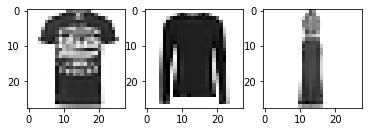

In [122]:
# Load MNIST dataset
DATA_PATH = './resources/ch3_part2.npz'
data = np.load(DATA_PATH)

sample_train = data['sample_train']
labels_train = data['labels_train']
sample_test = data['sample_test']

# Split train data
sample_train, sample_val, labels_train, labels_val = train_test_split(
    sample_train, labels_train, test_size=0.2, random_state=42)

# Visualize samples
fig = plt.figure()

LABELS = [0, 2, 3]
num_labels = len(LABELS)
for i in range(num_labels):
    ax = fig.add_subplot(1, num_labels, i+1)
    img = sample_train[labels_train==LABELS[i]][0].reshape((28, 28))
    ax.imshow(img, cmap="Greys")

次に，チュートリアルと同様に以下のデータセットの前処理をします

- 標準化
- 主成分分析(PCA)による次元圧縮
- 正規化

なおN_DIMを変えることで，次元数を変えることができます。

In [147]:
# Standardize
standard_scaler = StandardScaler()
sample_train = standard_scaler.fit_transform(sample_train)
sample_val = standard_scaler.transform(sample_val)
sample_test = standard_scaler.transform(sample_test)

# Reduce dimensions
N_DIM = 5
pca = PCA(n_components=N_DIM)
sample_train = pca.fit_transform(sample_train)
sample_val = pca.transform(sample_val)
sample_test = pca.transform(sample_test)

# Normalize
min_max_scaler = MinMaxScaler((-1, 1))
sample_train = min_max_scaler.fit_transform(sample_train)
sample_val = min_max_scaler.transform(sample_val)
sample_test = min_max_scaler.transform(sample_test)

### 2. モデリング

One-vs-Restアプローチに基づき，以下3つのQSVM二値分類モデルを作成しましょう。
- ラベル0 vs それ以外
- ラベル2 vs それ以外
- ラベル3 vs それ以外

ここでは，第一の二値分類モデルの実装をヒントとして示します。

### 2.1: ラベル0 vs それ以外
ラベル0をpositive (1)，それ以外をnegative (0) とした新しいラベルを以下のように作成します。

In [26]:
labels_train

array([2, 2, 3, 2, 3, 2, 3, 0, 2, 2, 3, 0, 2, 0, 3, 3, 2, 0, 3, 3, 2, 0,
       0, 0, 0, 3, 3, 0, 2, 2, 3, 2, 0, 2, 2, 2, 3, 3, 0, 2, 3, 0, 0, 3,
       2, 3, 0, 3, 2, 0, 3, 0, 0, 0, 2, 2, 2, 3, 2, 0, 3, 2, 2, 3, 2, 3,
       0, 3, 2, 0, 2, 2, 3, 2, 0, 2, 2, 3, 2, 0], dtype=uint8)

In [27]:
labels_train_0 = np.where(labels_train==0, 1, 0)
labels_val_0 = np.where(labels_val==0, 1, 0)

print(f'Original validation labels:      {labels_val}')
print(f'Validation labels for 0 vs Rest: {labels_val_0}')

Original validation labels:      [3 3 2 0 3 0 3 2 3 2 2 3 2 2 2 3 0 2 3 3]
Validation labels for 0 vs Rest: [0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0]


元々のラベルが0だった場所だけが1となっていることを確認してください。

次に，チュートリアルと同様にQSVMによって二値分類モデルを構築します。なお，このヒントではPauliFeatureMapを使用していますが，別の特徴マップを使用しても構いません。

In [66]:
pauli_map_0 = PauliFeatureMap(feature_dimension=N_DIM, reps=2, paulis = ['X', 'Y', 'ZZ'])
pauli_kernel_0 = QuantumKernel(feature_map=pauli_map_0, quantum_instance=Aer.get_backend('statevector_simulator'))

pauli_svc_0 = SVC(kernel='precomputed', probability=True)

matrix_train_0 = pauli_kernel_0.evaluate(x_vec=sample_train)
pauli_svc_0.fit(matrix_train_0, labels_train_0)

matrix_val_0 = pauli_kernel_0.evaluate(x_vec=sample_val, y_vec=sample_train)
pauli_score_0 = pauli_svc_0.score(matrix_val_0, labels_val_0)
print(f'Accuracy of discriminating between label 0 and others: {pauli_score_0*100}%')

Accuracy of discriminating between label 0 and others: 75.0%


QSVMの二値分類モデルは，ラベル0とそれ以外を一定の確率で区別できていることが分かります。

最後に各テストデータについてラベルが0である確率を計算します。これは``predict_proba``メソッドで求められます。

In [29]:
matrix_test_0 = pauli_kernel_0.evaluate(x_vec=sample_test, y_vec=sample_train)
pred_0 = pauli_svc_0.predict_proba(matrix_test_0)[:, 1]
print(f'Probability of label 0: {np.round(pred_0, 2)}')

Probability of label 0: [0.31 0.34 0.23 0.51 0.19 0.3  0.23 0.22 0.36 0.59 0.42 0.3  0.2  0.25
 0.45 0.56 0.41 0.53 0.34 0.2 ]


このようにして得られた確率は，多値分類において重要な手がかりとなります。

残り2つのラベルについても，同様に確率を求めます。

### 2.2: ラベル2 vs それ以外
QSVMを用いて二値分類モデルを構築し，各テストデータについてラベルが2である確率を計算してください。

In [ ]:
# !!!!!!!!!!!!!!!!!!!!!!!!
pauli_map = PauliFeatureMap(feature_dimension=N_DIM, reps=1, paulis = ['X', 'Y', 'ZZ'])
pauli_kernel = QuantumKernel(feature_map=pauli_map, quantum_instance=Aer.get_backend('statevector_simulator'))

matrix_train = pauli_kernel.evaluate(x_vec=sample_train)
matrix_val = pauli_kernel.evaluate(x_vec=sample_val, y_vec=sample_train)

pauli_svc = SVC(kernel='precomputed')
pauli_svc.fit(matrix_train, labels_train)
pauli_score = pauli_svc.score(matrix_val, labels_val)

print(f'Precomputed kernel classification test score: {pauli_score*100}%')

In [67]:
##############################
# Provide your code here

# ラベル2をpositive (1)，それ以外をnegative (0) とした新しいラベルを以下のように作成します。
labels_train_2 = np.where(labels_train==2, 1, 0)
labels_val_2 = np.where(labels_val==2, 1, 0)

# pauli_mapとkernel作成
pauli_map_2 = PauliFeatureMap(feature_dimension=N_DIM, reps=2, paulis = ['X', 'Y', 'ZZ'])
pauli_kernel_2 = QuantumKernel(feature_map=pauli_map_2, quantum_instance=Aer.get_backend('statevector_simulator'))

# SVC作成
pauli_svc_2 = SVC(kernel='precomputed', probability=True)

# 訓練用行列作成
matrix_train_2 = pauli_kernel_2.evaluate(x_vec=sample_train)
pauli_svc_2.fit(matrix_train_2, labels_train_2)

# 検証用行列作成
matrix_val_2 = pauli_kernel_2.evaluate(x_vec=sample_val, y_vec=sample_train)
pauli_score_2 = pauli_svc_2.score(matrix_val_2, labels_val_2)
print(f'Accuracy of discriminating between label 2 and others: {pauli_score_2*100}%')

matrix_test_2 = pauli_kernel_2.evaluate(x_vec=sample_test, y_vec=sample_train)
pred_2 = pauli_svc_2.predict_proba(matrix_test_2)[:, 1]


##############################

Accuracy of discriminating between label 0 and others: 75.0%


### 2.3 ラベル3 vs それ以外
QSVMを用いて二値分類モデルを構築し，各テストデータについてラベルが3である確率を計算してください。

In [110]:
##############################
# Provide your code here

# ラベル3をpositive (1)，それ以外をnegative (0) とした新しいラベルを以下のように作成します。
labels_train_3 = np.where(labels_train==3, 1, 0)
labels_val_3 = np.where(labels_val==3, 1, 0)

# pauli_mapとkernel作成
pauli_map_3 = PauliFeatureMap(feature_dimension=N_DIM, reps=2, paulis = ['X', 'Y', 'ZZ'])
pauli_kernel_3 = QuantumKernel(feature_map=pauli_map_3, quantum_instance=Aer.get_backend('statevector_simulator'))

# SVC作成
pauli_svc_3 = SVC(kernel='precomputed', probability=True)

# 訓練用行列作成
matrix_train_3 = pauli_kernel_3.evaluate(x_vec=sample_train)
pauli_svc_3.fit(matrix_train_3, labels_train_3)

# 検証用行列作成
matrix_val_3 = pauli_kernel_3.evaluate(x_vec=sample_val, y_vec=sample_train)
pauli_score_3 = pauli_svc_3.score(matrix_val_3, labels_val_3)
print(f'Accuracy of discriminating between label 3 and others: {pauli_score_3*100}%')

matrix_test_3 = pauli_kernel_3.evaluate(x_vec=sample_test, y_vec=sample_train)
pred_3 = pauli_svc_3.predict_proba(matrix_test_3)[:, 1]

##############################

Accuracy of discriminating between label 3 and others: 65.0%


### 3. 予測

最後に，各ラベルの確率に基づいて最終的な予測を行います。予測は以下の形式としてください。

In [134]:
sample_pred = np.load('./resources/ch3_part2_sub.npy')
print(f'Sample prediction: {sample_pred}')

Sample prediction: [0 0 0 0 0 0 2 2 2 2 2 2 3 3 3 3 3 3 3 3]


多値分類の予測方法を理解するために，まずはラベル2とラベル3の2つのラベルについて予測する場合を考えてみましょう。

あるデータに対して以下のような確率が得られていれば，ラベル2がより尤もらしいと考えられます。

- ラベル2である確率: 0.7
- ラベル3である確率: 0.2

これは ``np.where`` 関数によって以下のように実装できます。(別の方法を使っても構いません)

In [135]:
pred_2_ex = np.array([0.7])
pred_3_ex = np.array([0.2])

pred_test_ex = np.where((pred_2_ex > pred_3_ex), 2, 3)
print(f'Prediction: {pred_test_ex}')

Prediction: [2]


この方法は，そのまま複数データに拡張することができます。

第二のデータについて各ラベルの確率が以下のような場合，ラベル3がより尤もらしいと考えられます。

- ラベル2である確率: 0.1
- ラベル3である確率: 0.6

In [136]:
pred_2_ex = np.array([0.7, 0.1])
pred_3_ex = np.array([0.2, 0.6])

pred_test_ex = np.where((pred_2_ex > pred_3_ex), 2, 3)
print(f'Prediction: {pred_test_ex}')

Prediction: [2 3]


この方法は，3クラス分類の予測を行うためにも拡張することができます。  
この拡張手法を実装し，最終的な3クラス分類の予測を行ってください。

In [137]:
print(pred_0)

[0.30876253 0.33594356 0.23400166 0.51406299 0.18971929 0.30423181
 0.22734965 0.21540574 0.35537883 0.58804843 0.41523881 0.30464904
 0.19817469 0.25196031 0.44937831 0.56491499 0.40891301 0.53224039
 0.33924201 0.19857812]


In [138]:
print(pred_2)

[0.28988319 0.08106045 0.0521274  0.08866545 0.23003915 0.32027406
 0.30475725 0.49451999 0.07110653 0.40691189 0.04232524 0.48709367
 0.8760331  0.80514938 0.1813732  0.18946122 0.0573022  0.05962476
 0.28476768 0.6708444 ]


In [139]:
print(pred_3)

[0.18090135 0.41162484 0.57134816 0.41173867 0.57883615 0.36614537
 0.28842679 0.2548275  0.39111371 0.13120501 0.46078143 0.22456409
 0.14900839 0.17660082 0.23551524 0.20785351 0.62295058 0.20261459
 0.40701315 0.20678611]


In [140]:
pred_dammy = np.array([0]*len(pred_0))
print(pred_dammy)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [141]:

pred_all = np.vstack((pred_0, pred_dammy, pred_2, pred_3))
print(pred_all)

[[0.30876253 0.33594356 0.23400166 0.51406299 0.18971929 0.30423181
  0.22734965 0.21540574 0.35537883 0.58804843 0.41523881 0.30464904
  0.19817469 0.25196031 0.44937831 0.56491499 0.40891301 0.53224039
  0.33924201 0.19857812]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.28988319 0.08106045 0.0521274  0.08866545 0.23003915 0.32027406
  0.30475725 0.49451999 0.07110653 0.40691189 0.04232524 0.48709367
  0.8760331  0.80514938 0.1813732  0.18946122 0.0573022  0.05962476
  0.28476768 0.6708444 ]
 [0.18090135 0.41162484 0.57134816 0.41173867 0.57883615 0.36614537
  0.28842679 0.2548275  0.39111371 0.13120501 0.46078143 0.22456409
  0.14900839 0.17660082 0.23551524 0.20785351 0.62295058 0.20261459
  0.40701315 0.20678611]]


In [142]:
##############################
# Provide your code here

pred_test = np.argmax(pred_all, axis=0)
print(pred_test)

##############################

[0 3 3 0 3 3 2 2 3 0 3 2 2 2 0 0 3 0 3 2]


### 4. 提出
</div>
    
<div class="alert alert-block alert-success">

<b>Challenge 3c</b> 

**提出**: 以下の11個を提出してください。
- **pred_test**: 公開テストデータに対する予測
- **sample_train**: カーネル行列を計算するための訓練データ
- **standard_scaler**: 標準化に用いたスケーラー
- **pca**: 次元圧縮するために用いたPCA
- **min_max_scaler**: 正規化に用いたスケーラー
- **kernel_0**: 「ラベル0 vs それ以外」の二値分類に用いた``QuantumKernel``
- **kernel_2**: 「ラベル2 vs それ以外」の二値分類に用いた``QuantumKernel``
- **kernel_3**: 「ラベル3 vs それ以外」の二値分類に用いた``QuantumKernel``
- **svc_0**: 「ラベル0 vs それ以外」の二値分類に用いた``SVC``
- **svc_2**: 「ラベル0 vs それ以外」の二値分類に用いた``SVC``
- **svc_3**: 「ラベル0 vs それ以外」の二値分類に用いた``SVC``

**合格基準**: 公開テストデータと非公開テストデータ両方に対して70%以上の正解率

**スコア**: 合格基準を超えた解答は以下のようにして採点されます。このスコアは小さいほど良いことを表します。
    
1. 各特徴マップを以下の設定でトランスパイルします。
    - basis_gates=['u1', 'u2', 'u3', 'cx']
    - optimization_level=0
2. 各トランスパイル済み回路のコストを以下のように計算します。  
    cost = 10 * #cx + (#u1 + #u2 + #u3)
3. 3つのコストの合計がスコアになります。

</div>

提出する予測は以下の形式になっている必要があります。
- 公開テストデータ (**sample_test**) に対する予測
- type: numpy.ndarray
- shape: (20,)

In [128]:
print(pred_test)
print(type(pred_test))
print(pred_test.shape)

[0 0 3 0 3 3 2 2 0 3 3 2 2 2 3 2 3 0 2 2]
<class 'numpy.ndarray'>
(20,)


In [145]:
print(zzf_pred_test)
print(type(zzf_pred_test))
print(zzf_pred_test.shape)

[0 0 3 2 3 2 2 2 0 0 3 2 2 2 3 2 3 0 2 2]
<class 'numpy.ndarray'>
(20,)


In [113]:
print(f'Sample prediction: {sample_pred}')

Sample prediction: [0 0 0 0 0 0 2 2 2 2 2 2 3 3 3 3 3 3 3 3]


In [130]:
print(min_max_scaler)

MinMaxScaler(feature_range=(-1, 1))


In [19]:
# Load MNIST dataset
DATA_PATH = './resources/ch3_part2.npz'
data = np.load(DATA_PATH)

sample_train = data['sample_train']
labels_train = data['labels_train']
sample_test = data['sample_test']

# Split train data
sample_train, sample_val, labels_train, labels_val = train_test_split(
    sample_train, labels_train, test_size=0.2, random_state=42)

# Standardize
standard_scaler = StandardScaler()
sample_train = standard_scaler.fit_transform(sample_train)
sample_val = standard_scaler.transform(sample_val)
sample_test = standard_scaler.transform(sample_test)

# Reduce dimensions
N_DIM = 5 # 5
pca = PCA(n_components=N_DIM)
sample_train = pca.fit_transform(sample_train)
sample_val = pca.transform(sample_val)
sample_test = pca.transform(sample_test)

# Normalize
min_max_scaler = MinMaxScaler((-1, 1))
sample_train = min_max_scaler.fit_transform(sample_train)
sample_val = min_max_scaler.transform(sample_val)
sample_test = min_max_scaler.transform(sample_test)

REPS = 3  # 3
ENTANGLEMENT = "circular"  # this!
# ENTANGLEMENT = "full"
# ENTANGLEMENT = "linear"
###################################
# ZZFeatureMapを使う
###################################
# (0)
# 量子特徴マップと量子カーネルの作成
zzf_map_0 = ZZFeatureMap(feature_dimension=N_DIM, reps=REPS, entanglement=ENTANGLEMENT)
zzf_kernel_0 = QuantumKernel(feature_map=zzf_map_0, quantum_instance=Aer.get_backend('statevector_simulator'))

# 量子カーネル行列作成
zzf_matrix_train_0 = zzf_kernel_0.evaluate(x_vec=sample_train)
zzf_matrix_val_0   = zzf_kernel_0.evaluate(x_vec=sample_val, y_vec=sample_train)
zzf_matrix_test_0  = zzf_kernel_0.evaluate(x_vec=sample_test, y_vec=sample_train)

# ラベル作成
zzf_labels_train_0 = np.where(labels_train==0, 1, 0)
zzf_labels_val_0   = np.where(labels_val==0, 1, 0)

# SVC作成
zzf_svc_0 = SVC(kernel='precomputed', probability=True)
zzf_svc_0.fit(zzf_matrix_train_0, zzf_labels_train_0)
zzf_score_0 = zzf_svc_0.score(zzf_matrix_val_0, zzf_labels_val_0)
print(f'Accuracy of discriminating between label 0 and others: {zzf_score_0*100}%')

# 推論値を得る
zzf_pred_0 = zzf_svc_0.predict_proba(zzf_matrix_test_0)[:, 1]

# (2)
# 量子特徴マップと量子カーネルの作成
zzf_map_2 = ZZFeatureMap(feature_dimension=N_DIM, reps=REPS, entanglement=ENTANGLEMENT)
zzf_kernel_2 = QuantumKernel(feature_map=zzf_map_2, quantum_instance=Aer.get_backend('statevector_simulator'))

# 量子カーネル行列作成
zzf_matrix_train_2 = zzf_kernel_2.evaluate(x_vec=sample_train)
zzf_matrix_val_2   = zzf_kernel_2.evaluate(x_vec=sample_val, y_vec=sample_train)
zzf_matrix_test_2  = zzf_kernel_2.evaluate(x_vec=sample_test, y_vec=sample_train)

# ラベル作成
zzf_labels_train_2 = np.where(labels_train==2, 1, 0)
zzf_labels_val_2   = np.where(labels_val==2, 1, 0)

# SVC作成
zzf_svc_2 = SVC(kernel='precomputed', probability=True)
zzf_svc_2.fit(zzf_matrix_train_2, zzf_labels_train_2)
zzf_score_2 = zzf_svc_2.score(zzf_matrix_val_2, zzf_labels_val_2)
print(f'Accuracy of discriminating between label 2 and others: {zzf_score_2*100}%')

# 推論値を得る
zzf_pred_2 = zzf_svc_2.predict_proba(zzf_matrix_test_2)[:, 1]

# (3)
# 量子特徴マップと量子カーネルの作成
zzf_map_3 = ZZFeatureMap(feature_dimension=N_DIM, reps=REPS, entanglement=ENTANGLEMENT)
zzf_kernel_3 = QuantumKernel(feature_map=zzf_map_3, quantum_instance=Aer.get_backend('statevector_simulator'))

# 量子カーネル行列作成
zzf_matrix_train_3 = zzf_kernel_3.evaluate(x_vec=sample_train)
zzf_matrix_val_3   = zzf_kernel_3.evaluate(x_vec=sample_val, y_vec=sample_train)
zzf_matrix_test_3  = zzf_kernel_3.evaluate(x_vec=sample_test, y_vec=sample_train)

# ラベル作成
zzf_labels_train_3 = np.where(labels_train==3, 1, 0)
zzf_labels_val_3   = np.where(labels_val==3, 1, 0)

# SVC作成
zzf_svc_3 = SVC(kernel='precomputed', probability=True)
zzf_svc_3.fit(zzf_matrix_train_3, zzf_labels_train_3)
zzf_score_3 = zzf_svc_3.score(zzf_matrix_val_3, zzf_labels_val_3)
print(f'Accuracy of discriminating between label 3 and others: {zzf_score_3*100}%')

# 推論値を得る
zzf_pred_3 = zzf_svc_3.predict_proba(zzf_matrix_test_3)[:, 1]

# テストデータに対する予測
zzf_pred_dammy = np.array([0]*len(zzf_pred_0))
zzf_pred_all = np.vstack((zzf_pred_0, zzf_pred_dammy, zzf_pred_2, zzf_pred_3))
zzf_pred_test = np.argmax(zzf_pred_all, axis=0)
print(zzf_pred_test)

Accuracy of discriminating between label 0 and others: 90.0%
Accuracy of discriminating between label 2 and others: 80.0%
Accuracy of discriminating between label 3 and others: 70.0%
[0 0 0 3 3 3 0 0 0 0 3 2 2 2 3 2 3 0 2 2]


In [ ]:
# from qiskit_machine_learning.algorithms import QSVC

# # Load MNIST dataset
# DATA_PATH = './resources/ch3_part2.npz'
# data = np.load(DATA_PATH)

# sample_train = data['sample_train']
# labels_train = data['labels_train']
# sample_test = data['sample_test']

# # Split train data
# sample_train, sample_val, labels_train, labels_val = train_test_split(
#     sample_train, labels_train, test_size=0.2, random_state=42)

# # Standardize
# standard_scaler = StandardScaler()
# sample_train = standard_scaler.fit_transform(sample_train)
# sample_val = standard_scaler.transform(sample_val)
# sample_test = standard_scaler.transform(sample_test)

# # Reduce dimensions
# N_DIM = 5 # 5
# pca = PCA(n_components=N_DIM)
# sample_train = pca.fit_transform(sample_train)
# sample_val = pca.transform(sample_val)
# sample_test = pca.transform(sample_test)

# # Normalize
# min_max_scaler = MinMaxScaler((-1, 1))
# sample_train = min_max_scaler.fit_transform(sample_train)
# sample_val = min_max_scaler.transform(sample_val)
# sample_test = min_max_scaler.transform(sample_test)

# REPS = 2
# # ENTANGLEMENT = "circular"
# ENTANGLEMENT = "full"
# # ENTANGLEMENT = "linear"
# ###################################
# # ZZFeatureMapを使う
# ###################################
# # (0)
# # 量子特徴マップと量子カーネルの作成
# zzf_map_0 = ZZFeatureMap(feature_dimension=N_DIM, reps=REPS, entanglement=ENTANGLEMENT)
# zzf_kernel_0 = QuantumKernel(feature_map=zzf_map_0, quantum_instance=Aer.get_backend('statevector_simulator'))

# # 量子カーネル行列作成
# zzf_matrix_train_0 = zzf_kernel_0.evaluate(x_vec=sample_train)
# zzf_matrix_val_0   = zzf_kernel_0.evaluate(x_vec=sample_val, y_vec=sample_train)
# zzf_matrix_test_0  = zzf_kernel_0.evaluate(x_vec=sample_test, y_vec=sample_train)

# # ラベル作成
# zzf_labels_train_0 = np.where(labels_train==0, 1, 0)
# zzf_labels_val_0   = np.where(labels_val==0, 1, 0)

# # SVC作成
# zzf_svc_0 = QSVC(quantum_kernel=zzf_kernel_0, probability=True)
# zzf_svc_0.fit(zzf_matrix_train_0, zzf_labels_train_0)
# zzf_score_0 = zzf_svc_0.score(zzf_matrix_val_0, zzf_labels_val_0)
# print(f'Accuracy of discriminating between label 0 and others: {zzf_score_0*100}%')

# # 推論値を得る
# zzf_pred_0 = zzf_svc_0.predict_proba(zzf_matrix_test_0)[:, 1]

# # (2)
# # 量子特徴マップと量子カーネルの作成
# zzf_map_2 = ZZFeatureMap(feature_dimension=N_DIM, reps=REPS, entanglement=ENTANGLEMENT)
# zzf_kernel_2 = QuantumKernel(feature_map=zzf_map_2, quantum_instance=Aer.get_backend('statevector_simulator'))

# # 量子カーネル行列作成
# zzf_matrix_train_2 = zzf_kernel_2.evaluate(x_vec=sample_train)
# zzf_matrix_val_2   = zzf_kernel_2.evaluate(x_vec=sample_val, y_vec=sample_train)
# zzf_matrix_test_2  = zzf_kernel_2.evaluate(x_vec=sample_test, y_vec=sample_train)

# # ラベル作成
# zzf_labels_train_2 = np.where(labels_train==2, 1, 0)
# zzf_labels_val_2   = np.where(labels_val==2, 1, 0)

# # SVC作成
# # zzf_svc_2 = QSVC(kernel='precomputed', probability=True)
# zzf_svc_2 = QSVC(quantum_kernel=zzf_kernel_2, probability=True)
# zzf_svc_2.fit(zzf_matrix_train_2, zzf_labels_train_2)
# zzf_score_2 = zzf_svc_2.score(zzf_matrix_val_2, zzf_labels_val_2)
# print(f'Accuracy of discriminating between label 2 and others: {zzf_score_2*100}%')

# # 推論値を得る
# zzf_pred_2 = zzf_svc_2.predict_proba(zzf_matrix_test_2)[:, 1]

# # (3)
# # 量子特徴マップと量子カーネルの作成
# zzf_map_3 = ZZFeatureMap(feature_dimension=N_DIM, reps=REPS, entanglement=ENTANGLEMENT)
# zzf_kernel_3 = QuantumKernel(feature_map=zzf_map_3, quantum_instance=Aer.get_backend('statevector_simulator'))

# # 量子カーネル行列作成
# zzf_matrix_train_3 = zzf_kernel_3.evaluate(x_vec=sample_train)
# zzf_matrix_val_3   = zzf_kernel_3.evaluate(x_vec=sample_val, y_vec=sample_train)
# zzf_matrix_test_3  = zzf_kernel_3.evaluate(x_vec=sample_test, y_vec=sample_train)

# # ラベル作成
# zzf_labels_train_3 = np.where(labels_train==3, 1, 0)
# zzf_labels_val_3   = np.where(labels_val==3, 1, 0)

# # SVC作成
# zzf_svc_3 = QSVC(quantum_kernel=zzf_kernel_3, probability=True)
# zzf_svc_3.fit(zzf_matrix_train_3, zzf_labels_train_3)
# zzf_score_3 = zzf_svc_3.score(zzf_matrix_val_3, zzf_labels_val_3)
# print(f'Accuracy of discriminating between label 3 and others: {zzf_score_3*100}%')

# # 推論値を得る
# zzf_pred_3 = zzf_svc_3.predict_proba(zzf_matrix_test_3)[:, 1]

# # テストデータに対する予測
# zzf_pred_dammy = np.array([0]*len(zzf_pred_0))
# zzf_pred_all = np.vstack((zzf_pred_0, zzf_pred_dammy, zzf_pred_2, zzf_pred_3))
# zzf_pred_test = np.argmax(zzf_pred_all, axis=0)
# print(zzf_pred_test)

In [5]:
print(zzf_pred_0)
print(zzf_pred_2)
print(zzf_pred_3)

[0.28309556 0.28299323 0.28312821 0.28311102 0.28314902 0.28293804
 0.28313122 0.28289476 0.28303106 0.28273203 0.28312108 0.28309959
 0.28298131 0.28314376 0.28316783 0.28337259 0.28320285 0.28310257
 0.28312721 0.28327797]
[0.40254727 0.4026621  0.40249604 0.40244387 0.4025085  0.40261152
 0.40248732 0.40264664 0.40250532 0.40267911 0.40250011 0.40247555
 0.40252378 0.40244073 0.402474   0.40212359 0.40238559 0.40248362
 0.40248127 0.40192197]
[0.3049711  0.30494545 0.30499604 0.30507395 0.30496001 0.30506095
 0.30500292 0.30506564 0.30508643 0.30519812 0.30499877 0.30504934
 0.30511705 0.30504348 0.30498022 0.30517052 0.30504552 0.3050369
 0.3050141  0.30549997]


In [20]:
# kernel_0 = pauli_kernel_0
# kernel_2 = pauli_kernel_2
# kernel_3 = pauli_kernel_3
# svc_0 = pauli_svc_0
# svc_2 = pauli_svc_2
# svc_3 = pauli_svc_3

#################################
# ZZFeature
pred_test = zzf_pred_test
kernel_0 = zzf_kernel_0
kernel_2 = zzf_kernel_2
kernel_3 = zzf_kernel_3
svc_0 = zzf_svc_0
svc_2 = zzf_svc_2
svc_3 = zzf_svc_3

In [21]:
# 答えを確認して以下のコードで提出します
from qc_grader import grade_ex3c
grade_ex3c(pred_test, sample_train, 
           standard_scaler, pca, min_max_scaler,
           kernel_0, kernel_2, kernel_3,
           svc_0, svc_2, svc_3)

Submitting your answer for 3c. Please wait...
Failed: Gateway Time-out


## Additional information

**Created by:** Shota Nakasuji, Anna Phan

**Version:** 1.0.1